## # 최종 요약 하면서, 추가된 몇가지 실험
- 실험1 : xgboost 파라미터 동일한 상태에서, 최적의 sampling 비율 실험(K=30)
- 실험2 : sampling 비율 전략에 따른 최적이 n_estimators 찾기
- 실험3 : 

In [0]:
!pip install pylift
!pip install shap

In [0]:
from google.colab import auth
auth.authenticate_user() # auth를 통해 클라우드 권한을 얻는다! - bigquery 작업도 가능

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os

%matplotlib inline

In [0]:
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

In [0]:
from sklearn.model_selection import train_test_split
import pylift
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

## # 데이터 load

In [0]:
glob.glob('./gdrive/My Drive/Colab Notebooks/업무/*')

['./gdrive/My Drive/Colab Notebooks/업무/배송2.0_인기있는xxx',
 './gdrive/My Drive/Colab Notebooks/업무/DA_PLP비교분석',
 './gdrive/My Drive/Colab Notebooks/업무/Uplift']

In [0]:
# 작업 폴더
os.chdir('./gdrive/My Drive/Colab Notebooks/업무/Uplift')

In [0]:
%pwd

'/content/gdrive/My Drive/Colab Notebooks/업무/Uplift'

In [0]:
glob.glob('./*')

['./uplift_raw.csv',
 './uplift_raw_vo2_20190827.csv',
 './tmp.csv',
 './model_data.csv',
 './model_data_full.csv',
 './model_data_1.csv',
 './model_data_2.csv',
 './model_data_3.csv',
 './분석_v2.ipynb',
 './pylift탐색',
 './uplift_step2',
 './uplift_simulation',
 './result_1.xlsx',
 './result_20.xlsx',
 './분석_v1',
 './finalized_model.sav',
 './ttt.xlsx',
 './result1_model']



---



In [0]:
# 8월 27일 일자 2차 데이터
data = pd.read_csv('./uplift_raw_vo2_20190827.csv')

In [0]:
data.head()

,m_id,cont_group,start_date,end_date,min_value,max_valute,text_yn,mail_yn,last_buy_date,last_buy_seg,month,Y_buy_yn,Y_click_yn,Y_login_yn,Y_cart_yn,last_action,last_action_dt,day_cnt_last_action,access_yn,day_cnt_last_purchase,crm_url_click_cnt,reg_date,click_cnt,click_platform_cnt,search_cnt,vip_yn,download_coupon_cnt,crm_coupon_cnt,app_download_yn,day_cnt_app_exec,app_download_dt,cart_cnt,cart_category_cnt,cart_buy_cnt,sex,birth,last_login_dt,join_diff,join_platform,join_pay_diff,pay_cnt,pay_price,pay_period,pay_method,pay_cate,pay_platform,uv_cnt,ad_uv_yn
0,1000042,1,2019-05-08,2019-05-08,1,20,1,1,2015-10-02,12m~,5,0,0,0,0,cart,2019-04-07,31.0,1,1314,NaN,2010-10-08,46,3,9,1,1,6,1,29.0,2016-01-11,1,2,0,M,30대,~1m,8-9y,ETC,~3day,16,2365440,121,3,9,2,3,1
1,1000042,1,2019-06-18,2019-06-18,1,20,1,1,2015-10-02,12m~,6,0,0,0,0,click,2019-06-13,5.0,1,1355,NaN,2010-10-08,48,3,9,1,1,6,1,70.0,2016-01-11,1,2,0,M,30대,~1w,8-9y,ETC,~3day,16,2365440,121,3,9,2,4,1
2,1000109,1,2019-05-10,2019-05-10,1,20,1,1,2018-05-01,12m~,5,0,1,0,0,click,2019-05-08,2.0,1,374,NaN,2010-10-08,56,3,26,1,0,5,1,1.0,2016-09-09,0,0,0,M,30대,3_6m,8-9y,ETC,~3day,16,742700,184,3,12,3,0,0
3,1000109,1,2019-05-27,2019-05-27,1,20,1,1,2018-05-01,12m~,5,0,0,0,0,click,2019-05-10,17.0,1,391,NaN,2010-10-08,57,3,26,1,0,5,1,1.0,2016-09-09,0,0,0,M,30대,3_6m,8-9y,ETC,~3day,16,742700,184,3,12,3,0,0
4,1000109,1,2019-06-10,2019-06-10,1,20,1,1,2018-05-01,12m~,6,0,0,0,0,click,2019-05-10,31.0,1,405,NaN,2010-10-08,57,3,26,1,0,5,1,15.0,2016-09-09,0,0,0,M,30대,3_6m,8-9y,ETC,~3day,16,742700,184,3,12,3,0,0


In [0]:
data.info()  # 총 48개의 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9594519 entries, 0 to 9594518
Data columns (total 48 columns):
m_id                     int64
cont_group               int64
start_date               object
end_date                 object
min_value                int64
max_valute               int64
text_yn                  int64
mail_yn                  int64
last_buy_date            object
last_buy_seg             object
month                    int64
Y_buy_yn                 int64
Y_click_yn               int64
Y_login_yn               int64
Y_cart_yn                int64
last_action              object
last_action_dt           object
day_cnt_last_action      float64
access_yn                int64
day_cnt_last_purchase    int64
crm_url_click_cnt        float64
reg_date                 object
click_cnt                int64
click_platform_cnt       int64
search_cnt               int64
vip_yn                   int64
download_coupon_cnt      int64
crm_coupon_cnt           int64
app_down

In [0]:
data.columns

Index(['m_id', 'cont_group', 'start_date', 'end_date', 'min_value',
       'max_valute', 'text_yn', 'mail_yn', 'last_buy_date', 'last_buy_seg',
       'month', 'Y_buy_yn', 'Y_click_yn', 'Y_login_yn', 'Y_cart_yn',
       'last_action', 'last_action_dt', 'day_cnt_last_action', 'access_yn',
       'day_cnt_last_purchase', 'crm_url_click_cnt', 'reg_date', 'click_cnt',
       'click_platform_cnt', 'search_cnt', 'vip_yn', 'download_coupon_cnt',
       'crm_coupon_cnt', 'app_download_yn', 'day_cnt_app_exec',
       'app_download_dt', 'cart_cnt', 'cart_category_cnt', 'cart_buy_cnt',
       'sex', 'birth', 'last_login_dt', 'join_diff', 'join_platform',
       'join_pay_diff', 'pay_cnt', 'pay_price', 'pay_period', 'pay_method',
       'pay_cate', 'pay_platform', 'uv_cnt', 'ad_uv_yn'],
      dtype='object')

---

# 1. Preprocessing

## # data preprocessing -> train/test split 전에 실시
- 4가지 step
- **drop_columns** 메소드 : 모델에 쓰이지 않을 9개의 변수를 제거
- **col_to_categorical** 메소드 : categorical 변수로 활용하는 변수(13개)
> 나중에 SHAP을 이용한 해석에서 categorical 변수의 순서? 를 파악할 필요가 있기에 order 선언(예를들어 1년 < 2년 임을 알려주기위해)

- **quantile_cut** 메소드 : 동일한 높이의 bin으로 범주값을 만든다 (default  변수:day_cnt_last_action)
- **last_encoding** 메소드 : **categorical변수를 int형으로 변환하며**, return값 no_modeling_features, numerical_features, categorical_features 을 갖는다.





In [0]:
data_tmp = data.copy()

### 1.1 drop_columns 

In [0]:
# drop non-using columns

def drop_columns(df):
  df.drop(columns = ['last_buy_date', 'last_buy_seg', 'last_action_dt', 'crm_url_click_cnt', 'reg_date', 'app_download_dt', 'day_cnt_app_exec', 'min_value' , 'max_valute'], inplace=True)

In [0]:
drop_columns(data_tmp)

In [0]:
data_tmp.shape

(9594519, 39)

### 1.2 col_to_categorical

In [0]:
from pandas.api.types import CategoricalDtype

# categorical 변수들을 지정해준다(+변환)
def col_to_categorical(df):
  cate_cols = ['text_yn', 'mail_yn', 'last_action', 'access_yn', 'join_diff', 
               'vip_yn', 'app_download_yn', 'sex', 'birth', 'last_login_dt', 
               'join_platform', 'join_pay_diff', 'ad_uv_yn'] # 이 cate_cols를 이용할지도 모르니깐

  #'text_yn'
  df['text_yn'] = pd.Categorical(df['text_yn']) 
  # 'mail_yn'
  df['mail_yn'] = pd.Categorical(df['mail_yn'])  

  #last_action : null값 존재
  df['last_action'] = df['last_action'].fillna('None')
  df['last_action'] = pd.Categorical(df['last_action'])

  # 'access_yn'
  df['access_yn'] = pd.Categorical(df['access_yn'])  

  # 'join_diff'
  df['join_diff'] = pd.Categorical(df['join_diff'])  
  cat_type = CategoricalDtype(categories = ['1-2y', '2-3y', '3-4y', '4-5y', '5-6y', '6-7y', '7-8y', '8-9y', 'etc'], ordered = True)
  df['join_diff'] = df['join_diff'].astype(cat_type)

  # 'vip_yn'
  df['vip_yn'] = pd.Categorical(df['vip_yn'])  

  # 'app_download_yn'
  df['app_download_yn'] = pd.Categorical(df['app_download_yn'])

  # 'sex'
  df['sex'] = pd.Categorical(df['sex'])

  # 'birth'
  df['birth'] = df['birth'].replace(['10대', '20대', '30대', '40대', '50대', '60대', '기타'], ['10s', '20s', '30s', '40s', '50s', '60s', 'etc'])
  df['birth'] = pd.Categorical(df['birth'])
  cat_type = CategoricalDtype(categories = ['10s', '20s', '30s', '40s', '50s', '60s', 'etc'], ordered = True)
  df['birth'] = df['birth'].astype(cat_type)

  # 'last_login_dt'
  df['last_login_dt'] = pd.Categorical(df['last_login_dt'])
  cat_type = CategoricalDtype(categories = ['~3day', '~1w', '~2w', '~1m', '1_3m', '3_6m', '6_12m', '12m~'], ordered = True)
  df['last_login_dt'] = df['last_login_dt'].astype(cat_type)

  # 'join_platform'
  df['join_platform'] = pd.Categorical(df['join_platform'])  

  # 'join_pay_diff'
  df['join_pay_diff'] = pd.Categorical(df['join_pay_diff'])
  cat_type = CategoricalDtype(categories = ['~3day', '~1w', '~2w', '~1m', '1_3m', '3_6m', '6_12m', '12m~'], ordered = True)
  df['join_pay_diff'] = df['join_pay_diff'].astype(cat_type)

  # 'ad_uv_yn'
  df['ad_uv_yn'] = pd.Categorical(df['ad_uv_yn']) 

  #return df # 굳이 필요없다

In [0]:
col_to_categorical(data_tmp)

In [0]:
data_tmp.dtypes

m_id                        int64
cont_group                  int64
start_date                 object
end_date                   object
text_yn                  category
mail_yn                  category
month                       int64
Y_buy_yn                    int64
Y_click_yn                  int64
Y_login_yn                  int64
Y_cart_yn                   int64
last_action              category
day_cnt_last_action       float64
access_yn                category
day_cnt_last_purchase       int64
click_cnt                   int64
click_platform_cnt          int64
search_cnt                  int64
vip_yn                   category
download_coupon_cnt         int64
crm_coupon_cnt              int64
app_download_yn          category
cart_cnt                    int64
cart_category_cnt           int64
cart_buy_cnt                int64
sex                      category
birth                    category
last_login_dt            category
join_diff                category
join_platform 

### 1.3 quantile_cut

In [0]:
### equal sized bins : day_cnt_last_action -> to categorical

def quantile_cut(df, col = 'day_cnt_last_action'): # 기본 col의 setting 은 'day_cnt_last_action' 이다!
  
  df[col] = pd.qcut(df[col], 10)
  df[col] = df[col].cat.add_categories("None").fillna("None") # null 값에 해당하는 "None"범주 추가한다!

  #return df # 굳이 필요없다

In [0]:
quantile_cut(data_tmp)

In [0]:
data_tmp.dtypes # day_cnt_last_action category 형태

m_id                        int64
cont_group                  int64
start_date                 object
end_date                   object
text_yn                  category
mail_yn                  category
month                       int64
Y_buy_yn                    int64
Y_click_yn                  int64
Y_login_yn                  int64
Y_cart_yn                   int64
last_action              category
day_cnt_last_action      category
access_yn                category
day_cnt_last_purchase       int64
click_cnt                   int64
click_platform_cnt          int64
search_cnt                  int64
vip_yn                   category
download_coupon_cnt         int64
crm_coupon_cnt              int64
app_download_yn          category
cart_cnt                    int64
cart_category_cnt           int64
cart_buy_cnt                int64
sex                      category
birth                    category
last_login_dt            category
join_diff                category
join_platform 

#### 1.4 last_encoding

In [0]:
# Feature 순서 + categorical to int

def last_encoding(df):
  no_modeling_features = ['m_id'
  ,'cont_group'
  ,'start_date'
  ,'end_date'
  ,'month'
  ,'Y_buy_yn'
  ,'Y_click_yn'
  ,'Y_login_yn'
  ,'Y_cart_yn']

  numerical_features = ['day_cnt_last_purchase'
  ,'click_cnt'
  ,'click_platform_cnt'
  ,'search_cnt'
  ,'download_coupon_cnt'
  ,'crm_coupon_cnt'
  ,'cart_cnt'
  ,'cart_category_cnt'
  ,'cart_buy_cnt'
  ,'pay_cnt'
  ,'pay_price'
  ,'pay_period'
  ,'pay_method'
  ,'pay_cate'
  ,'pay_platform'
  ,'uv_cnt']
  # 0. 대조군 '3' 을 '0' 으로 바꿔준다
  df['cont_group'] = df['cont_group'].replace(3, 0)

  # 1. categorical 변수 인식하기
  categorical_features = df.select_dtypes(['category']).columns
  
  # 2. categorical -> int형으로(xgboost에선 차이 없어보인다)
  df[categorical_features] = df[categorical_features].apply(lambda x: x.cat.codes)

  return no_modeling_features, numerical_features, categorical_features

In [0]:
no_modeling_features, numerical_features, categorical_features = last_encoding(data_tmp)

In [0]:
# 사용할 features들의 순서를 이렇게 맞춰주었다! - 혹시 몰라서

data_tmp = data_tmp[no_modeling_features + numerical_features + categorical_features.tolist()]

In [0]:
data_tmp.head()

,m_id,cont_group,start_date,end_date,month,Y_buy_yn,Y_click_yn,Y_login_yn,Y_cart_yn,day_cnt_last_purchase,click_cnt,click_platform_cnt,search_cnt,download_coupon_cnt,crm_coupon_cnt,cart_cnt,cart_category_cnt,cart_buy_cnt,pay_cnt,pay_price,pay_period,pay_method,pay_cate,pay_platform,uv_cnt,text_yn,mail_yn,last_action,day_cnt_last_action,access_yn,vip_yn,app_download_yn,sex,birth,last_login_dt,join_diff,join_platform,join_pay_diff,ad_uv_yn
0,1000042,1,2019-05-08,2019-05-08,5,0,0,0,0,1314,46,3,9,1,6,1,2,0,16,2365440,121,3,9,2,3,1,1,1,2,1,1,1,1,2,3,7,1,0,1
1,1000042,1,2019-06-18,2019-06-18,6,0,0,0,0,1355,48,3,9,1,6,1,2,0,16,2365440,121,3,9,2,4,1,1,2,0,1,1,1,1,2,1,7,1,0,1
2,1000109,1,2019-05-10,2019-05-10,5,0,1,0,0,374,56,3,26,0,5,0,0,0,16,742700,184,3,12,3,0,1,1,2,0,1,1,1,1,2,5,7,1,0,0
3,1000109,1,2019-05-27,2019-05-27,5,0,0,0,0,391,57,3,26,0,5,0,0,0,16,742700,184,3,12,3,0,1,1,2,1,1,1,1,1,2,5,7,1,0,0
4,1000109,1,2019-06-10,2019-06-10,6,0,0,0,0,405,57,3,26,0,5,0,0,0,16,742700,184,3,12,3,0,1,1,2,2,1,1,1,1,2,5,7,1,0,0


# 2. train/test split
- '7월 21일 전/후' 로 data-split
- data_train : uplift 모델 '훈련' 데이터
- data_test : uplift 모델 '테스트' 데이터 (평가 목적)

In [0]:
# data-split - (기준):2019-07-21 전/후

data_train = data_tmp[data_tmp.start_date <= '2019-07-21'].reset_index(drop=True).copy()
data_test = data_tmp[data_tmp.start_date > '2019-07-21'].reset_index(drop=True).copy()

In [0]:
print(data_train.shape, ',' , data_test.shape) #  맞다!

(8848876, 39) , (745643, 39)



# 3. Uplift 모델링 - using XGBoost
- 기본적으로 쿠폰 발급을 통해 '구매전환'(Y_buy_yn) 이 이루어졌는지 예측하는 모델링을 한다
- 사용 모델 : XGBoost(pylift에서는 데이터 transform을 통해 XGBoostRegressor를 이용하게된다 - not classificiation)
- 상당한 Imbalanced 데이터이기 때문에(평균적으로 실험군 구매전환률 0.3377%, 대조군 : 0.2793%) <br/> **Under sampling**을 이용한다. (precision보단 **recall**을 올리는데 치중)


> over-sampling x



In [0]:
data_train.columns

Index(['m_id', 'cont_group', 'start_date', 'end_date', 'month', 'Y_buy_yn',
       'Y_click_yn', 'Y_login_yn', 'Y_cart_yn', 'day_cnt_last_purchase',
       'click_cnt', 'click_platform_cnt', 'search_cnt', 'download_coupon_cnt',
       'crm_coupon_cnt', 'cart_cnt', 'cart_category_cnt', 'cart_buy_cnt',
       'pay_cnt', 'pay_price', 'pay_period', 'pay_method', 'pay_cate',
       'pay_platform', 'uv_cnt', 'text_yn', 'mail_yn', 'last_action',
       'day_cnt_last_action', 'access_yn', 'vip_yn', 'app_download_yn', 'sex',
       'birth', 'last_login_dt', 'join_diff', 'join_platform', 'join_pay_diff',
       'ad_uv_yn'],
      dtype='object')

In [0]:
# 실제 모델링에 사용될 32개의 Features(2개의 labels, 30개의 features)
used_cols = ['cont_group', 'Y_buy_yn','day_cnt_last_purchase',
       'click_cnt', 'click_platform_cnt', 'search_cnt', 'download_coupon_cnt',
       'crm_coupon_cnt', 'cart_cnt', 'cart_category_cnt', 'cart_buy_cnt',
       'pay_cnt', 'pay_price', 'pay_period', 'pay_method', 'pay_cate',
       'pay_platform', 'uv_cnt', 'text_yn', 'mail_yn', 'last_action',
       'day_cnt_last_action', 'access_yn', 'vip_yn', 'app_download_yn', 'sex',
       'birth', 'last_login_dt', 'join_diff', 'join_platform', 'join_pay_diff',
       'ad_uv_yn']

In [0]:
len(used_cols)

32

In [0]:
data_train_ = data_train[used_cols].copy()

In [0]:
data_train_.shape

(8848876, 32)

---

## # Under sampling(1:1)
- 여러 비율(1:1, 1:5, 1:10 등)을 활용 할 수 있다 - Simulation을 하였고, '최적의 비율'에 대한 논의 필요
- 1:1은 sampled data에 대해 모델이 흔들린다(모델 variance)

In [0]:
### 실험 조건에 맞는 index sampling - 실험 조건 : 'size'

size = 1 # 1:1 under sampling 
cr_1 = data_train_[data_train_['Y_buy_yn']==1].shape[0] # train 데이터에서 '구매자 수'
index_list = data_train_[data_train_['Y_buy_yn']==0].sample( n=cr_1 * size ).index # 구매x 에서 
index_list_1 = data_train_[data_train_['Y_buy_yn']==1].index
sampling_index_list = index_list.tolist()+index_list_1.tolist()


### sampled data
data_samp  = data_train_.iloc[ sampling_index_list ]

### uplift input 데이터 정의 - train/test
data_input = (data_samp, data_test[used_cols] )

In [0]:
print(data_input[0].shape, data_input[1].shape) # train/test

(57666, 32) (745643, 32)




---



---



## # Uplift 

In [0]:
up = pylift.TransformedOutcome( data_input , col_treatment='cont_group', col_outcome='Y_buy_yn' )

In [0]:
up.transformed_y_train.value_counts()

 0.000000     28833
 1.081676     26985
-13.243467     1848
Name: TransformedOutcome, dtype: int64

In [0]:
up.transformed_y_test.value_counts()

 0.000000     743174
 1.081676       2311
-13.243467       158
Name: TransformedOutcome, dtype: int64

In [0]:
up.fit(  )

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[08:14:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
up.test_results_.prediction.max()

1.5508605

In [0]:
up.test_results_.prediction.min()

-9.237649



---



---



## # 모델 에버리징 (k=100)  - (1:1 under sampling)

In [0]:
import pickle

In [0]:
for i in range(100):
  ### 실험 조건에 맞는 index sampling - 실험 조건 : 'size'

  size = 1 # 1:1 under sampling 
  cr_1 = data_train_[data_train_['Y_buy_yn']==1].shape[0] # train 데이터에서 '구매자 수'
  index_list = data_train_[data_train_['Y_buy_yn']==0].sample( n=cr_1 * size ).index # 구매x 에서 
  index_list_1 = data_train_[data_train_['Y_buy_yn']==1].index
  sampling_index_list = index_list.tolist()+index_list_1.tolist()


  ### sampled data
  data_samp  = data_train_.iloc[ sampling_index_list ]

  ### uplift input 데이터 정의 - train/test
  data_input = (data_samp, data_test[used_cols] )

  up = pylift.TransformedOutcome( data_input , col_treatment='cont_group', col_outcome='Y_buy_yn' )
  up.fit(  )

  # save the model to disk
  filename = 'result1_model/finalized_model_result1_{}.sav'.format(i)
  pickle.dump(up.model, open(filename, 'wb'))

In [0]:
range(30,100)

range(30, 100)

In [0]:
result_list = []

for i in range(100):
  # load the model from disk
  filename = 'result1_model/finalized_model_result1_{}.sav'.format(i)

  loaded_model = pickle.load(open(filename, 'rb'))
  result = loaded_model.predict( data_test[['day_cnt_last_purchase', 'click_cnt',
       'click_platform_cnt', 'search_cnt', 'download_coupon_cnt',
       'crm_coupon_cnt', 'cart_cnt', 'cart_category_cnt', 'cart_buy_cnt',
       'pay_cnt', 'pay_price', 'pay_period', 'pay_method', 'pay_cate',
       'pay_platform', 'uv_cnt', 'text_yn', 'mail_yn', 'last_action',
       'day_cnt_last_action', 'access_yn', 'vip_yn', 'app_download_yn', 'sex',
       'birth', 'last_login_dt', 'join_diff', 'join_platform', 'join_pay_diff',
       'ad_uv_yn']] )
  result_list.append( result )

[09:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
len(result_list)

100

In [0]:
result_list[0]

array([ 0.09247866, -0.10019833,  0.49799448, ...,  0.13960168,
        0.11068514,  0.08747151], dtype=float32)

In [0]:
np.array(result_list).mean(axis=0).shape

(745643,)

In [0]:
result_mean = np.array(result_list).mean(axis=0)

In [0]:
data_test['prediction'] = result_mean

In [0]:
data_test.head()

,m_id,cont_group,start_date,end_date,month,Y_buy_yn,Y_click_yn,Y_login_yn,Y_cart_yn,day_cnt_last_purchase,click_cnt,click_platform_cnt,search_cnt,download_coupon_cnt,crm_coupon_cnt,cart_cnt,cart_category_cnt,cart_buy_cnt,pay_cnt,pay_price,pay_period,pay_method,pay_cate,pay_platform,uv_cnt,text_yn,mail_yn,last_action,day_cnt_last_action,access_yn,vip_yn,app_download_yn,sex,birth,last_login_dt,join_diff,join_platform,join_pay_diff,ad_uv_yn,prediction
0,1000109,1,2019-07-31,2019-07-31,7,0,0,0,0,456,59,3,26,0,6,0,0,0,16,742700,184,3,12,3,0,1,1,2,2,1,1,1,1,2,4,7,1,0,0,0.091937
1,1000205,1,2019-07-26,2019-07-26,7,0,0,0,0,418,33,2,2,0,7,0,0,0,6,295800,493,3,5,1,0,0,1,2,7,1,1,0,2,6,0,7,1,6,0,-0.117863
2,1000934,1,2019-07-26,2019-07-26,7,0,0,0,0,373,132,3,31,1,6,0,0,0,29,1265600,101,1,19,3,4,1,1,2,1,1,1,1,0,2,3,7,1,0,1,0.472443
3,1001481,0,2019-07-25,2019-07-25,7,0,0,0,0,392,28,1,4,0,5,0,0,1,13,499350,235,2,7,2,1,1,1,2,9,1,1,0,2,2,5,7,1,0,0,-0.114621
4,1002444,1,2019-07-29,2019-07-29,7,0,0,0,0,391,48,1,26,0,5,0,0,0,65,9697500,43,3,20,2,0,1,1,0,10,0,1,1,1,3,4,7,1,4,0,0.316356


In [0]:
data_test['quantile_label'] = pd.qcut(data_test.prediction, 10, labels=False)



---



---
## # 각각의 Test일자에 대해서 quantile group의 구매전환률


In [0]:
test_grp = [grp[1] for grp in data_test.groupby('start_date')]

In [0]:
len(test_grp) # test일자에는 8개의 캠페인이 존재한다!

8

In [0]:
test_grp_trt = []
test_grp_cont = []
for i in range(len(test_grp)):
  test_grp_trt.append( test_grp[i][test_grp[i].cont_group == 1].copy() )
  test_grp_cont.append( test_grp[i][test_grp[i].cont_group == 0].copy() )

In [0]:
print( len(test_grp_trt), len(test_grp_cont))

8 8


In [0]:
for i in range(len(test_grp_trt)):
  test_grp_trt[i]['quantile_label'] = pd.qcut(test_grp_trt[i].prediction, 10, labels=False)
  test_grp_cont[i]['quantile_label'] = pd.qcut(test_grp_cont[i].prediction, 10, labels=False)

In [0]:
# trt : 계층별 구매전환률
for i in range(len(test_grp_trt)):
  for label in range(0,10):
    print( '{} :'.format(label), test_grp_trt[i][(test_grp_trt[i].quantile_label == label) & (test_grp_trt[i].Y_buy_yn == 1)].shape[0]/test_grp_trt[i][test_grp_trt[i].quantile_label == label].shape[0] )

  print('\n')

0 : 0.0028359511343804536
1 : 0.0022905759162303663
2 : 0.002617801047120419
3 : 0.0017452006980802793
4 : 0.0026149487905861844
5 : 0.0025114653854553396
6 : 0.0028359511343804536
7 : 0.0029450261780104713
8 : 0.004690226876090751
9 : 0.006217277486910994


0 : 0.0037222163139423586
1 : 0.002020846628376941
2 : 0.0018081259306530525
3 : 0.0022335673261008296
4 : 0.002977773051153887
5 : 0.0022335673261008296
6 : 0.0037226122101680493
7 : 0.0018081259306530525
8 : 0.0048925760476494365
9 : 0.006912687440178667


0 : 0.003913128546272745
1 : 0.003130502837018196
2 : 0.0015655577299412916
3 : 0.004694835680751174
4 : 0.0035231943628890195
5 : 0.002934846409704559
6 : 0.003913894324853229
7 : 0.004693917465284568
8 : 0.007047768206734534
9 : 0.008804539229113676


0 : 0.002880049817077917
1 : 0.0013232661321709348
2 : 0.001867558944829196
3 : 0.001868722261153936
4 : 0.002179497158869775
5 : 0.0030357281855686153
6 : 0.0027243714485872188
7 : 0.0030357281855686153
8 : 0.004436833501984899

In [0]:
# cont : 계층별 구매전환률
for i in range(len(test_grp_cont)):
  for label in range(0,10):
    print( '{} :'.format(label), test_grp_cont[i][(test_grp_cont[i].quantile_label == label) & (test_grp_cont[i].Y_buy_yn == 1)].shape[0]/test_grp_cont[i][test_grp_cont[i].quantile_label == label].shape[0] )

  print('\n')

0 : 0.006675567423230975
1 : 0.00267379679144385
2 : 0.0013351134846461949
3 : 0.0
4 : 0.004005340453938585
5 : 0.004010695187165776
6 : 0.0053475935828877
7 : 0.0
8 : 0.0
9 : 0.0013351134846461949


0 : 0.002564102564102564
1 : 0.001282051282051282
2 : 0.002564102564102564
3 : 0.0
4 : 0.002564102564102564
5 : 0.001282051282051282
6 : 0.0025673940949935813
7 : 0.002564102564102564
8 : 0.0038461538461538464
9 : 0.001282051282051282


0 : 0.0
1 : 0.0
2 : 0.004761904761904762
3 : 0.0
4 : 0.004761904761904762
5 : 0.007142857142857143
6 : 0.007159904534606206
7 : 0.0
8 : 0.0
9 : 0.004761904761904762


0 : 0.002898550724637681
1 : 0.0
2 : 0.002898550724637681
3 : 0.006769825918762089
4 : 0.000966183574879227
5 : 0.001932367149758454
6 : 0.004835589941972921
7 : 0.001932367149758454
8 : 0.002898550724637681
9 : 0.005797101449275362


0 : 0.003978779840848806
1 : 0.0
2 : 0.0013280212483399733
3 : 0.0013280212483399733
4 : 0.00398406374501992
5 : 0.0026560424966799467
6 : 0.0013280212483399733


In [0]:

# cont : 계층별 구매전환률
for i in range(len(test_grp_cont)):
  for label in range(0,10):
    print( '{} :'.format(label), test_grp_trt[i][(test_grp_trt[i].quantile_label == label) & (test_grp_trt[i].Y_buy_yn == 1)].shape[0]/test_grp_trt[i][test_grp_trt[i].quantile_label == label].shape[0]
          - test_grp_cont[i][(test_grp_cont[i].quantile_label == label) & (test_grp_cont[i].Y_buy_yn == 1)].shape[0]/test_grp_cont[i][test_grp_cont[i].quantile_label == label].shape[0])

  print('\n')

0 : -0.0038396162888505213
1 : -0.0003832208752134838
2 : 0.0012826875624742241
3 : 0.0017452006980802793
4 : -0.0013903916633524007
5 : -0.0014992298017104362
6 : -0.0025116424485072467
7 : 0.0029450261780104713
8 : 0.004690226876090751
9 : 0.004882164002264799


0 : 0.0011581137498397945
1 : 0.0007387953463256589
2 : -0.0007559766334495116
3 : 0.0022335673261008296
4 : 0.000413670487051323
5 : 0.0009515160440495476
6 : 0.001155218115174468
7 : -0.0007559766334495116
8 : 0.0010464222014955902
9 : 0.005630636158127385


0 : 0.003913128546272745
1 : 0.003130502837018196
2 : -0.0031963470319634705
3 : 0.004694835680751174
4 : -0.0012387103990157428
5 : -0.004208010733152584
6 : -0.003246010209752977
7 : 0.004693917465284568
8 : 0.007047768206734534
9 : 0.004042634467208914


0 : -1.8500907559764173e-05
1 : 0.0013232661321709348
2 : -0.0010309917798084851
3 : -0.004901103657608153
4 : 0.001213313583990548
5 : 0.0011033610358101612
6 : -0.0021112184933857023
7 : 0.0011033610358101612
8 : 0

---

## # 1:1 under sampling 결과를 통한 prediction 계층별 전환률 비교
- under sampling 안했을때와 차이 본다!

In [0]:
data_test['prediction'] = up.test_results_.prediction

In [0]:
data_test_trt = data_test[data_test.cont_group == 1][['Y_buy_yn', 'cont_group', 'prediction']].copy()

In [0]:
data_test_cont = data_test[data_test.cont_group == 0][['Y_buy_yn', 'cont_group', 'prediction']].copy()

In [0]:
data_test_trt['quantile_label'] = pd.qcut(data_test_trt.prediction, 10, labels=False)

In [0]:
data_test_trt.head()

,Y_buy_yn,cont_group,prediction,quantile_label
0,0,1,0.099920,6
1,0,1,-0.167954,0
2,0,1,0.459937,9
4,0,1,0.375324,9
6,0,1,0.064137,5


In [0]:
for label in range(0,10):
  print( '{} :'.format(label), data_test_trt[data_test_trt.quantile_label == label].shape[0] )

0 : 69399
1 : 69217
2 : 68084
3 : 68930
4 : 68870
5 : 68902
6 : 68898
7 : 68947
8 : 68853
9 : 68900


In [0]:
data_test_trt[data_test_trt.quantile_label == 9].prediction.min()

0.1831916

In [0]:
data_test_trt[data_test_trt.quantile_label == 9].prediction.max()

1.5508605

In [0]:
# 계층별 구매전환자 수
for label in range(0,10):
  print( '{} :'.format(label), data_test_trt[(data_test_trt.quantile_label == label) & (data_test_trt.Y_buy_yn == 1)].shape[0] )

0 : 211
1 : 173
2 : 122
3 : 157
4 : 182
5 : 202
6 : 220
7 : 243
8 : 326
9 : 475


In [0]:
(0.68+0.47)/2

0.575

In [0]:
# 계층별 구매전환률
for label in range(0,10):
  print( '{} :'.format(label), data_test_trt[(data_test_trt.quantile_label == label) & (data_test_trt.Y_buy_yn == 1)].shape[0]/data_test_trt[data_test_trt.quantile_label == label].shape[0] )

0 : 0.0030403896309745097
1 : 0.002499385988991144
2 : 0.0017919041184419247
3 : 0.002277673001595822
4 : 0.00264266008421664
5 : 0.002931700095788221
6 : 0.003193126070422944
7 : 0.0035244463138352647
8 : 0.004734724703353521
9 : 0.006894049346879536


In [0]:
data_test[data_test.prediction == data_test.prediction.max()]

,m_id,cont_group,start_date,end_date,month,Y_buy_yn,Y_click_yn,Y_login_yn,Y_cart_yn,day_cnt_last_purchase,click_cnt,click_platform_cnt,search_cnt,download_coupon_cnt,crm_coupon_cnt,cart_cnt,cart_category_cnt,cart_buy_cnt,pay_cnt,pay_price,pay_period,pay_method,pay_cate,pay_platform,uv_cnt,text_yn,mail_yn,last_action,day_cnt_last_action,access_yn,vip_yn,app_download_yn,sex,birth,last_login_dt,join_diff,join_platform,join_pay_diff,ad_uv_yn,prediction
360327,15246408,1,2019-07-22,2019-07-22,7,0,0,0,0,474,959,1,405,24,7,7,4,4,170,2648763,6,3,13,1,17,1,1,4,0,1,1,1,0,3,0,2,3,0,0,1.550861


In [0]:
data_test[data_test.index == 373055] # under sampling 없을때,  prediction 1등

,m_id,cont_group,start_date,end_date,month,Y_buy_yn,Y_click_yn,Y_login_yn,Y_cart_yn,day_cnt_last_purchase,click_cnt,click_platform_cnt,search_cnt,download_coupon_cnt,crm_coupon_cnt,cart_cnt,cart_category_cnt,cart_buy_cnt,pay_cnt,pay_price,pay_period,pay_method,pay_cate,pay_platform,uv_cnt,text_yn,mail_yn,last_action,day_cnt_last_action,access_yn,vip_yn,app_download_yn,sex,birth,last_login_dt,join_diff,join_platform,join_pay_diff,ad_uv_yn,prediction
373055,15528875,1,2019-07-30,2019-07-30,7,0,0,0,0,515,73,2,16,12,5,1,1,0,3,82600,455,1,2,2,11,1,1,4,0,1,0,0,0,2,4,2,2,0,1,0.647048


In [0]:
## control
data_test_cont['quantile_label'] = pd.qcut(data_test_cont.prediction, 10, labels=False)

In [0]:
data_test_cont.head()

,Y_buy_yn,cont_group,prediction,quantile_label
3,0,0,-0.027834,1
5,0,0,0.193578,9
9,0,0,0.108659,7
38,0,0,0.022743,3
95,0,0,0.365911,9


In [0]:
for label in range(0,10):
  print( '{} :'.format(label), data_test_cont[data_test_cont.quantile_label == label].shape[0] )

0 : 5665
1 : 5664
2 : 5665
3 : 5668
4 : 5660
5 : 5692
6 : 5637
7 : 5665
8 : 5662
9 : 5665


In [0]:
# 계층별 구매전환자 수
for label in range(0,10):
  print( '{} :'.format(label), data_test_cont[(data_test_cont.quantile_label == label) & (data_test_cont.Y_buy_yn == 1)].shape[0] )

0 : 17
1 : 8
2 : 13
3 : 16
4 : 13
5 : 17
6 : 24
7 : 18
8 : 18
9 : 14


In [0]:
# 계층별 구매전환률
for label in range(0,10):
  print( '{} :'.format(label), data_test_cont[(data_test_cont.quantile_label == label) & (data_test_cont.Y_buy_yn == 1)].shape[0]/data_test_cont[data_test_cont.quantile_label == label].shape[0] )

0 : 0.003000882612533098
1 : 0.0014124293785310734
2 : 0.002294792586054722
3 : 0.0028228652081863093
4 : 0.0022968197879858657
5 : 0.0029866479269149682
6 : 0.004257583821181479
7 : 0.003177405119152692
8 : 0.0031790886612504416
9 : 0.002471315092674316




---



---



---



# # 시뮬레이션2
- under sampling 속성에 해당하는 best iteration 찾기

In [0]:
def simulation_(size, n_estimators_ = None):
  # size=1(equal), 3(3times), 5(5times), 10(10times)
  
  #실험 조건에 맞는 index sampling
  cr_1 = data_train_[data_train_['Y_buy_yn']==1].shape[0] # train데이터에서 구매자 수
  index_list = data_train_[data_train_['Y_buy_yn']==0].sample( n=cr_1 * size ).index # s
  index_list_1 = data_train_[data_train_['Y_buy_yn']==1].index
  sampling_index_list = index_list.tolist()+index_list_1.tolist()

  #sampled data
  data_samp  = data_train_.iloc[ sampling_index_list ]

  ##실험
  data_input = (data_samp, data_test[used_cols] )
  up = pylift.TransformedOutcome( data_input , col_treatment='cont_group', col_outcome='Y_buy_yn' )
  up.fit( n_estimators = n_estimators_ )

  ##### 값 만들기
  data_test_w_prediction = pd.concat([data_test[['Y_buy_yn', 'cont_group']], pd.DataFrame({'prediction': up.test_results_.prediction })], axis=1) # prediction을 붙여주어서 값을 계산한다
  data_test_w_prediction.reset_index(inplace=True)

  top_10p_index = data_test_w_prediction.sort_values(by='prediction', ascending=False).iloc[:int(data_test_w_prediction.shape[0]*0.1),:].index
  bottom_10p_index = data_test_w_prediction.sort_values(by='prediction').iloc[:int(data_test_w_prediction.shape[0]*0.1),:].index

  ##### 상위 10% 계산값
  tt = data_test_w_prediction.iloc[top_10p_index, :]
  top_conversion, top_trt_conversion, top_cont_conversion = tt.Y_buy_yn.sum()/tt.shape[0] , tt[tt.cont_group==1].Y_buy_yn.sum()/tt[tt.cont_group==1].shape[0], tt[tt.cont_group==0].Y_buy_yn.sum()/tt[tt.cont_group==0].shape[0]


  ##### 하위 10% 계산값
  tt_ = data_test_w_prediction.iloc[bottom_10p_index, :]
  bottom_conversion, bottom_trt_conversion, bottom_cont_conversion = tt_.Y_buy_yn.sum()/tt_.shape[0], tt_[tt_.cont_group==1].Y_buy_yn.sum()/tt_[tt_.cont_group==1].shape[0], tt_[tt_.cont_group==0].Y_buy_yn.sum()/tt_[tt_.cont_group==0].shape[0]

  
  return (top_conversion, top_trt_conversion, top_cont_conversion, bottom_conversion, bottom_trt_conversion, bottom_cont_conversion), up.test_results_.q1_cgains, up.test_results_.q1_aqini , up.test_results_.cgains_x , up.test_results_.cgains_y , up.test_results_.uplift_y

In [0]:
## 1:1

for n_iter in [40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]:
  result, q1_cgains, q1_aqini, cgains_x, cgains_y, uplift_y = simulation_(20, n_estimators_ = n_iter) # 1:20 에서
  if n_iter == 40:
    result_list = [list(result)]
    q1_cgains_list = [q1_cgains]
    q1_aqini_list = [q1_aqini]
    cgains_x_list = [cgains_x]
    cgains_y_list = [cgains_y]
    uplift_y_list = [uplift_y]
  else:
    result_list = np.append(result_list, [result], axis=0)
    q1_cgains_list.append(q1_cgains)
    q1_aqini_list.append(q1_aqini)
    cgains_x_list = np.append(cgains_x_list, [cgains_x], axis=0)
    cgains_y_list = np.append(cgains_y_list, [cgains_y], axis=0)
    uplift_y_list = np.append(uplift_y_list, [uplift_y], axis=0)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:53:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:55:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:58:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:08:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


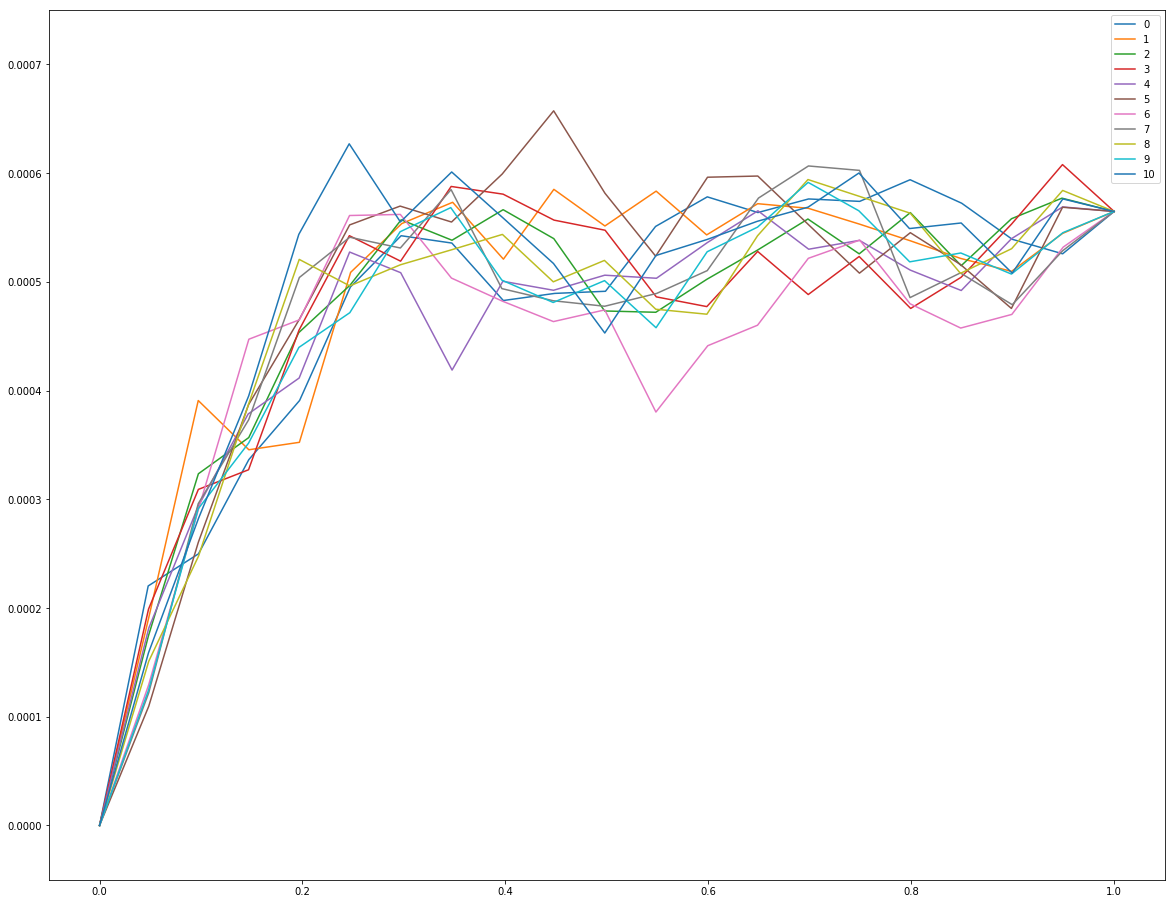

In [0]:
plt.figure(figsize=(20,16))
plt.ylim(-0.00005, 0.00075)
for i in range(len(cgains_x_list)):
  plt.plot(cgains_x_list[i], cgains_y_list[i], label=i)
  plt.legend()

In [0]:
q1_cgains_list

[0.06601468815982134,
 0.065572101481311,
 0.06625040091750216,
 0.06397587948422556,
 0.05882606937733419,
 0.07187858288188924,
 0.052491233508889325,
 0.060928179253018196,
 0.06363340810303408,
 0.06131608599506729,
 0.07120574134402124]

In [0]:
import pandas as pd

In [0]:
pd.DataFrame({'n_iter' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240], 
              'q1_cgains': [0.06601468815982134, 0.065572101481311, 0.06625040091750216, 0.06397587948422556, 0.05882606937733419, 0.07187858288188924, 0.052491233508889325, 0.060928179253018196, 0.06363340810303408, 0.06131608599506729, 0.07120574134402124]})

,n_iter,q1_cgains
0,40,0.066015
1,60,0.065572
2,80,0.066250
3,100,0.063976
4,120,0.058826
5,140,0.071879
6,160,0.052491
7,180,0.060928
8,200,0.063633
9,220,0.061316


In [0]:
q1_aqini_list

[0.06713228596402074,
 0.06668123635291996,
 0.06748269170592676,
 0.06526420573340683,
 0.05997116712654372,
 0.07316697191364528,
 0.05366517896825986,
 0.062090248898482976,
 0.0648879979953174,
 0.0626108508426011,
 0.0725393736025456]

In [0]:
pd.DataFrame({'n_iter' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240], 
              'q1_aqini': [0.06713228596402074, 0.06668123635291996, 0.06748269170592676, 0.06526420573340683, 0.05997116712654372, 0.07316697191364528, 0.05366517896825986, 0.062090248898482976, 0.0648879979953174, 0.0626108508426011, 0.0725393736025456]})

,n_iter,q1_aqini
0,40,0.067132
1,60,0.066681
2,80,0.067483
3,100,0.065264
4,120,0.059971
5,140,0.073167
6,160,0.053665
7,180,0.062090
8,200,0.064888
9,220,0.062611


In [0]:
result_1 = pd.DataFrame(data = result_list, columns = ['top_conversion', 'top_trt_conversion', 'top_cont_conversion', 'bottom_conversion', 'bottom_trt_conversion', 'bottom_cont_conversion'])

In [0]:
result_1.head()

,top_conversion,top_trt_conversion,top_cont_conversion,bottom_conversion,bottom_trt_conversion,bottom_cont_conversion
0,0.010595,0.010779,0.008215,0.001971,0.001990,0.001749
1,0.010099,0.010385,0.006379,0.002199,0.002239,0.001725
2,0.009991,0.010228,0.006925,0.002280,0.002283,0.002241
3,0.009495,0.009723,0.006549,0.002508,0.002516,0.002417
4,0.009576,0.009791,0.006772,0.002280,0.002297,0.002073


In [0]:
result_1.to_excel('./result_20.xlsx')

In [0]:
## 1:1

for n_iter in [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]:
  result, q1_cgains, q1_aqini, cgains_x, cgains_y, uplift_y = simulation_(1, n_estimators_ = n_iter) # 1:20 에서
  if n_iter == 20:
    result_list = [list(result)]
    q1_cgains_list = [q1_cgains]
    q1_aqini_list = [q1_aqini]
    cgains_x_list = [cgains_x]
    cgains_y_list = [cgains_y]
    uplift_y_list = [uplift_y]
  else:
    result_list = np.append(result_list, [result], axis=0)
    q1_cgains_list.append(q1_cgains)
    q1_aqini_list.append(q1_aqini)
    cgains_x_list = np.append(cgains_x_list, [cgains_x], axis=0)
    cgains_y_list = np.append(cgains_y_list, [cgains_y], axis=0)
    uplift_y_list = np.append(uplift_y_list, [uplift_y], axis=0)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:43:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


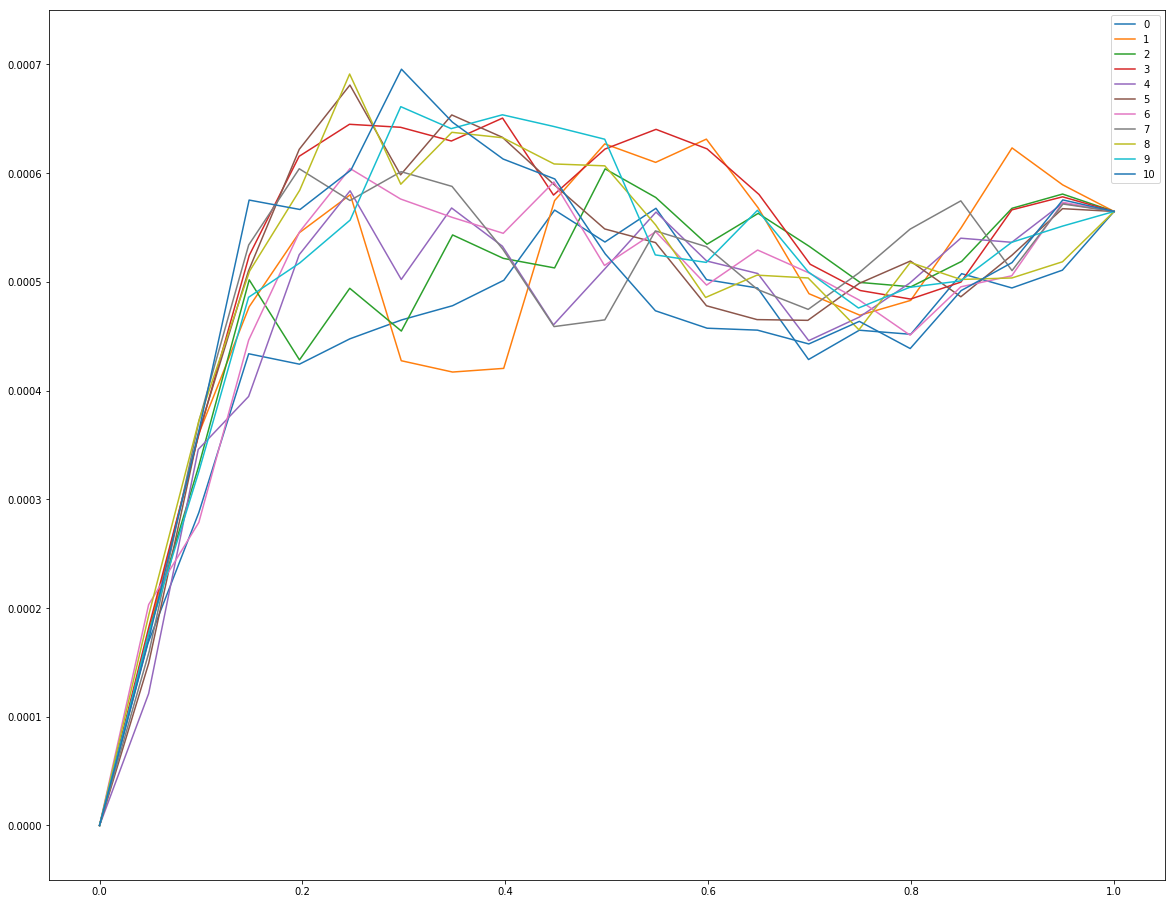

In [0]:
plt.figure(figsize=(20,16))
plt.ylim(-0.00005, 0.00075)
for i in range(len(cgains_x_list)):
  plt.plot(cgains_x_list[i], cgains_y_list[i], label=i)
  plt.legend()

In [0]:
q1_cgains_list

[0.05498815146162873,
 0.07018385202431417,
 0.06689822102241483,
 0.08344858211250644,
 0.06197440993856318,
 0.07238853393419972,
 0.06507690939597247,
 0.06874685551785431,
 0.07611776753162226,
 0.07662248980075086,
 0.07114187017664982]

In [0]:
q1_aqini_list

[0.05607273529301219,
 0.07134403230276104,
 0.06802262881447083,
 0.08489924579754003,
 0.06317983875202601,
 0.07381642827863093,
 0.06627677654438777,
 0.07003562177646615,
 0.07743824600447682,
 0.07798964379356076,
 0.07229091538111143]

In [0]:
pd.DataFrame({'n_iter' : [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220], 
              'q1_cgains':[0.05498815146162873, 0.07018385202431417, 0.06689822102241483, 0.08344858211250644, 0.06197440993856318, 
                           0.07238853393419972, 0.06507690939597247, 0.06874685551785431, 0.07611776753162226, 0.07662248980075086, 0.07114187017664982],
              'q1_aqini':[0.05607273529301219, 0.07134403230276104, 0.06802262881447083, 0.08489924579754003, 0.06317983875202601, 0.07381642827863093, 
                          0.06627677654438777, 0.07003562177646615, 0.07743824600447682, 0.07798964379356076, 0.07229091538111143]})

,n_iter,q1_cgains,q1_aqini
0,20,0.054988,0.056073
1,40,0.070184,0.071344
2,60,0.066898,0.068023
3,80,0.083449,0.084899
4,100,0.061974,0.063180
5,120,0.072389,0.073816
6,140,0.065077,0.066277
7,160,0.068747,0.070036
8,180,0.076118,0.077438
9,200,0.076622,0.077990


In [0]:
result_ = pd.DataFrame(data = result_list, columns = ['top_conversion', 'top_trt_conversion', 'top_cont_conversion', 'bottom_conversion', 'bottom_trt_conversion', 'bottom_cont_conversion'])

In [0]:
result_.head()

,top_conversion,top_trt_conversion,top_cont_conversion,bottom_conversion,bottom_trt_conversion,bottom_cont_conversion
0,0.006773,0.006984,0.004070,0.002897,0.002950,0.002260
1,0.006598,0.006863,0.003175,0.002950,0.002906,0.003485
2,0.006867,0.007110,0.003729,0.003286,0.003284,0.003309
3,0.006800,0.007061,0.003388,0.003111,0.003110,0.003124
4,0.006679,0.006933,0.003378,0.003031,0.003052,0.002774


In [0]:
result_.to_excel('./result_1.xlsx')